In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from py_ball import playbyplay, boxscore, team
import time
import numpy as np
from sklearn import linear_model
import pickle

In [2]:
headers = {
    'Accept-Encoding': 'gzip, deflate, sdch',
    'Accept-Language': 'en-US,en;q=0.8,ru;q=0.6',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
    'Referer': 'https://stats.nba.com/teams/boxscores-traditional/',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'
}

In [3]:
TOTAL_GAMES_PER_YEAR = 1230

In [12]:
with open('model.pickle', 'rb') as model:
    time_to_model = pickle.load(model)

In [13]:
def get_seconds_left(period, time_string):
    time_in_quarter = 12 #normal quarter is 12 minutes long
    if period > 4:
        time_in_quarter=5 #if it's overtime, 5 mins long
    mins, seconds = time_string.split(':') #from a string like "11:20", we have 11 mins, 20 seconds
    extra_after_quarter = (4-period)*time_in_quarter*60 
    if period > 4:
        #if overtime, we go into negatives, so 10 seconds into overtime is -10 and so on
        extra_after_quarter = (5-period)*time_in_quarter*60 
        time_elapsed = (time_in_quarter*60) - ((int(mins)*60)+(int(seconds))) # convert to seconds
        return extra_after_quarter-time_elapsed
    else:
        return extra_after_quarter+(int(mins)*60)+(int(seconds)) #convert to seconds

In [16]:
"""
Here, we are getting data in the same format as we do with the train set (check out that notebook for in depth comments)
The code is essentially the same, with some minor tweaks.
"""
def get_test(game_id):
    test_x = []
    test_y = []
    times = []
    diff = []
    pbp = playbyplay.PlayByPlay(headers=headers, game_id=game_id).data
    bxscore = boxscore.BoxScore(headers=headers, game_id=game_id, endpoint='boxscoresummaryv2').data
    team_abr = []
    game_summary = (bxscore['GameSummary'])[0]
    home_team_id = game_summary['HOME_TEAM_ID']
    visitor_team_id = game_summary['VISITOR_TEAM_ID']
    
    home_team_data = team.Team(headers=headers, endpoint='teaminfocommon', team_id=home_team_id).data
    visitor_team_data = team.Team(headers=headers, endpoint='teaminfocommon', team_id=visitor_team_id).data
    
    home = home_team_data['TeamInfoCommon'][0]['TEAM_ABBREVIATION']
    away = visitor_team_data['TeamInfoCommon'][0]['TEAM_ABBREVIATION']
        
    jump_event = pbp['PlayByPlay'][1]
    home_has_ball = (jump_event['HOMEDESCRIPTION'] != None)
    current_quarter = 1
    current_margin = 0
    home_wins = int(pbp['PlayByPlay'][-1]['SCOREMARGIN']) > 0
    last_second = 2880
    game_x = {}
    game_y = []
    added_this_game = []
    actual_times = []        
            
    for event in pbp['PlayByPlay'][2:]:

        seconds_left_in_game = get_seconds_left(event['PERIOD'], event['PCTIMESTRING'])

        for sec in range(seconds_left_in_game+1, last_second):
            if sec % 10 == 0 and (sec not in added_this_game):
                game_x[sec] = [current_margin, home_wins, home_has_ball]
                game_y.append(int(home_wins))
                added_this_game.append(sec)

        last_second = seconds_left_in_game

        home_desc = (event['HOMEDESCRIPTION'] != None)
        visitor_desc = (event['VISITORDESCRIPTION'] != None)

        if home_desc and not visitor_desc:
            home_has_ball = True

        if visitor_desc and not home_desc:
            home_has_ball = False

        if home_desc and visitor_desc:
            if ('STEAL' in event['HOMEDESCRIPTION']) or ('BLOCK' in event['HOMEDESCRIPTION']):
                home_has_ball = True
            else:
                home_has_ball = False

        if event['SCOREMARGIN'] != None:
            margin = 0
            if event['SCOREMARGIN'] != 'TIE':
                margin = (int(event['SCOREMARGIN']))
                current_margin = margin

        if seconds_left_in_game % 10 == 0 and seconds_left_in_game not in added_this_game:  
            game_x[seconds_left_in_game] = [current_margin, home_wins, home_has_ball]
            game_y.append(int(home_wins))
            added_this_game.append(int(seconds_left_in_game))

        test_x = (game_x)
        times = (list(game_x.keys()))
        diff.append(current_margin)
        actual_times.append(seconds_left_in_game)
        
    return test_x, times, diff, actual_times, home, away
    

In [17]:
"""
given the game_id we can plot the win probability
"""
def plot_probs_for_test(game_id, model=time_to_model, plot_wp=True):
    print(game_id)
    test_x, times, diff, actual_times, home, away = get_test(game_id)
    times = np.insert(times, 0, 2880)
    probs = []
    for time in times[1:]:
        time_prob = model[time].predict_proba([[test_x[time][0], test_x[time][2]]])[0]
        probs.append(time_prob)
    
    probs = np.array(probs)
    
    probs_home = np.insert(probs[:,0], 0, 0.5)
    probs_away = np.insert(probs[:,1], 0, 0.5)
    
    end_lim = 2880-(len(probs_home)*10)
    
    if plot_wp:
        fig, ax = plt.subplots(1,2)
        ax[0].set_title("Point Differential")
        ax[0].plot(actual_times, diff)
        ax[0].set_xlim(2880, end_lim)
        ax[1].plot(times, probs_home, label=home)
        ax[1].plot(times, probs_away, label=away)
        ax[1].set_xlim(2880, end_lim)
        ax[1].set_ylim(0.0, 1.0)
        ax[1].set_title("Win Probability")
        plt.legend(loc='best')
        plt.show()
    
    return probs_home, probs_away, home, away

In [24]:
plt.rcParams["figure.figsize"] = (20,6)

0021900960


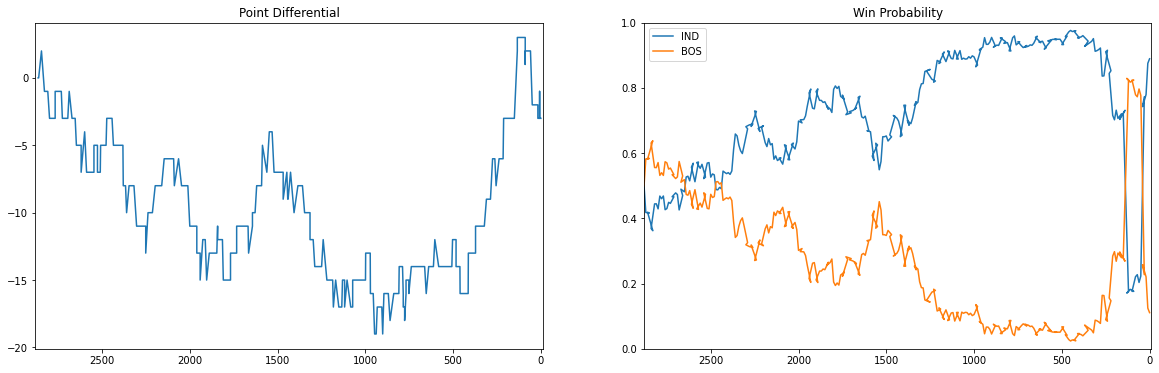

In [28]:
probs_home, probs_away, home, away = plot_probs_for_test("0021900960", plot_wp=True)